# Strategy types
FiMDP currently offers 3 energy solver classes.
 * `BasicES`: the basic energy solver used by default, thi implements the algorithm presented in our [CAV2020 paper],
 * `GoalLeaningES`: a solver that tries to heurisitcally decrease the expected time needed to visit the targets, and
 * `LeastFixpointES`: solver that uses a least-fixpoint iteration instead of largest-fixpoint to compute the Safety objective. See [examples/SafeByLeastFixpoint.ipynb](examples/SafeByLeastFixpoint.ipynb) for more details.
 
In this notebook, we will focus on the imporovements introduced by the goal-leaning solver. In particular, we will focus on the Büchi objective __expected reachability time (ERT)__, which is the expected number of steps we need to reach some target state in a sample run generated by strategies. Both the basic and goal-leaning solvers provide the following:
 * solve almost-sure Büchi objective and
 * compute the minimal initial load needed in each state.
In other words, both solvers have the same guarantees from the perspective of the Büchi objective. They differ in the strategies they produce. The goal of the goal-leaning solver is not only provide these guarantees but also to be **usable in practical control case studies**.

We start with the disadvantage of the basic solver.

[CAV2020 paper]: https://doi.org/10.1007/978-3-030-53291-8_22

In [1]:
import fimdp
fimdp.setup()

### Simple goal-leaning example

Consider the following example ConsMDP. In state 0, both actions lead to the state 1 with some probability and otherwise stay in 0. And they do this with the same consumption. In other words, they are equally good for reaching the green state if we ignore the transition probabilities.

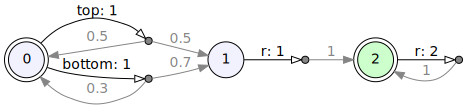

In [2]:
from fimdp.examples.cons_mdp import goal_leaning
gl, T = goal_leaning()
gl.show(targets=T)

The basic solver completely ignores the transition probabilities and chooses **any** of the two actions. In fact, it chooses the one that was added as the first at the creation of the ConsMDP. In our case, it chooses the action `top`. The goal-leaning solver chooses `bottom`, which has a bigger probability to move on.

In [3]:
from fimdp.energy_solvers import BasicES, GoalLeaningES
from fimdp.objectives import BUCHI

basic = BasicES(gl, 10, targets=T)
goal = GoalLeaningES(gl, 10, targets=T)
print(f"Selection rule for state 0 given by the basic solver:", basic.get_selector(BUCHI)[0])
print(f"Selection rule for state 0 given by the goal-leaning solver:", goal.get_selector(BUCHI)[0])

Selection rule for state 0 given by the basic solver: {
  0+: top
}
Selection rule for state 0 given by the goal-leaning solver: {
  0+: bottom
}


What is the change? When choosing from equally good actions, the goal-leaning solver chooses the most-likely successful action.

#### More technical explenation
The measure of *goodness* in the sentence above means *low value of `action_value_T`, which is the least amount of energy needed to satisfy the objective by this action*. The `action_value_T` is $\mathit{SPR-Val}$ in the CAV paper. And basically, this value is sufficient to play this action and always survive, and continue towards targets if we are lucky and the outcome of this action is the one desired. In contrast with the Basic solver, `action_value_T` returns not only the action value, but also the probability that the outcome of this action will the one that produced this value. Then from actions with minimal value we choose the one with the highest probability of reaching the desired outcome.

In [4]:
result = goal.get_selector(BUCHI)[0][0].label
expected = 'bottom'
assert result == expected, (
    f"The goal-leaning strategy should prefer the action `{expected}` " +
    f"in state 0. It chooses `{result}` instead."
)

## Thresholds

Now consider the following example. From state 0, we can reach the green state 3 in one step (and 1 unit of energy) if we are extremely lucky (action `direct`), ERT=201. Or we can play safe, choose `long` and reach the state in two steps (and 2 units of energy) surely, ERT=2.

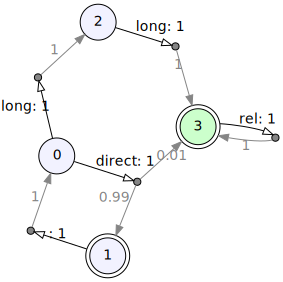

In [5]:
from fimdp.examples.cons_mdp import two_step
mdp, T = two_step()
mdp.show(targets=T)

The goal-leaning solver itself fails here to pick the action `long` and thus produce a strategy with the best possible expected reachability time (ERT).

In [6]:
basic = BasicES(mdp, cap=10, targets=T)
goal = GoalLeaningES(mdp, cap=10, targets=T)
print(basic.get_selector(BUCHI)[0])
print(goal.get_selector(BUCHI)[0])

{
  1+: direct
}
{
  1+: direct
}


The reason is that `direct` has a better action value (1, the best possible) than `long` (2 = consumption of `long` + 1 [the green value of state 2] on the picture below).

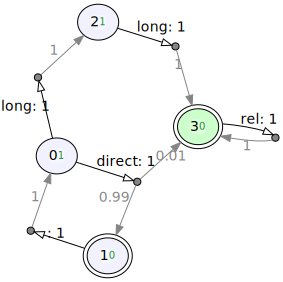

In [7]:
basic.show()

The goal-leaning solver accepts a parameter `threshold`. Intuitively, the solver just ignores all outcomes with lower probability than the threshold when computing the `action_value_T`. This means, it does not rely on unlikely outcomes when choosing actions, if possible.

In [8]:
threshold = GoalLeaningES(mdp, cap=10, targets=T, threshold=0.011)
print(threshold.get_selector(BUCHI)[0])

{
  1 — 1: direct,
  2+: long
}


The _if possible_ above refers to the cases where we start with resource level too low to ignore action with low probability to move towards the goals. In our case, that is level=1, as seen in the selection rule above. The generated action selector uses `long` whenever possible (energy at least 2) and `direct` otherwise. This means that the ERT is 2 for energy at least 2, and is 3.96 for energy 1 and capacity at least 3.

In [9]:
result = {k: v.label for k, v in threshold.get_selector(BUCHI)[0].items()}
expected = {2: 'long', 1: 'direct'}
assert result == expected, ("The threshold strategy should return\n" +
                           f"{expected} in state 0.\n" +
                           f"{result} returned in 0.")

# The practical impact of goal-leaning solver

We now demonstrate the impact of goal-leaning solver on practical controller synthesis problems.

We use a simple gridworld underwater environment generated by [FiMDPEnv]. We have some pre-defined environments in the file [env.py](env.py). The goal of the agent is to reach the green target with sufficient energy so that it can reach it again and again.

In each cell of the gridworld, the agent can choose one of eight possible actions. For each of the 4 directions (`NORTH`, `SOUTH`, `WEST`, `EAST`) the agent chooses whether to play a *weak* or _strong_ action. A strong action costs more energy, while the weak action has uncertain outcome. The resulting direction of movement can be affected by pre-defined currents. For example, in most cases, picking `EAST` can, with a small probability end up with the agent going `SOUTH` or `NORTH`.

[FiMDP]: https://github.com/xblahoud/FiMDP
[FiMDPEnv]: https://github.com/pthangeda/FiMDPEnv

In [10]:
import fimdpenv
fimdpenv.setup()
from env import create_env

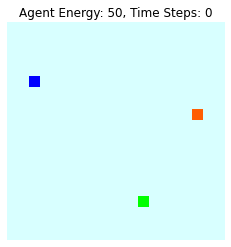

In [11]:
e = create_env('2R-1T-simple', heading_sd=0.32, agent_capacity=50)
e

The colors of the gridworld cells have the following semantics:
 * <font color='blue'>Blue Cell</font>: Current location of the agent
 * <font color='gray'>Gray Cells</font>: Trajectory of the agent
 * <font color='green'>Green Cells</font>: Target States
 * <font color='orange'>Orange Cells</font>: Reload states

The following two functions will help us to investigate the strategies generated by different solvers for our problem.

In [12]:
def showcase_solver(SolverClass, gw=e, steps=100, capacity=60, **solver_args):
    gw.reset(gw.init_states)
    gw.capacities[0]=capacity
    gw.energies[0]=capacity
    gw.create_counterstrategy(SolverClass, fimdp.objectives.BUCHI, **solver_args)
    return gw.animate_simulation(num_steps=steps)
    
def strategy_at(SolverClass, state, gw=e, steps=100, capacity=40, **solver_args):
    gw.agent_capacity=capacity
    m, t = gw.get_consmdp()
    solver = SolverClass(m, capacity, t, **solver_args)
    strategy = solver.get_selector(fimdp.objectives.BUCHI)
    return strategy[state]

Let's start with the basic solver.

In [13]:
showcase_solver(BasicES, capacity=50)

While the generated strategy guarantees that the agent eventually reaches the target with probability 1, it might take an enourmous number of steps before it really happens. As the basic solver does ignore probabilities of action-outcomes complete, all actions with `SOUTH` as a possible outcome are equally good for this solver. The algorithm processes `EAST` before `SOUTH` and thus `EAST` is preffered. The agent then hopes to go `SOUTH` using the action `EAST`. Not a smart one as the agent only moves to `SOUTH` on rare events...

In [14]:
s = e.reloads[0]
reload = e.consmdp.reloads.index(True)
strategy_at(BasicES, s, capacity=50)

{0: 177——Weak East[1]——>{157: 0.16, 178: 0.78, 197: 0.06}}

Above, we can see that for all values of energy, the strategy chooses action that goes `EAST` in the bottom reload state `s`.

Now let's look at the strategy generated by the Goal-leaning solver.

In [15]:
from fimdp.energy_solvers import GoalLeaningES
showcase_solver(GoalLeaningES, capacity=50)

In [16]:
strategy_at(GoalLeaningES, s, capacity=50)

{0: 177——Weak South[1]——>{176: 0.07, 178: 0.14, 197: 0.79}}

This looks much better. If the agent has enough energy in `s`, it tries to go `SOUTH`. Only with a low level of resource the agent goes to `EAST`, towards the reload state.

### Goal-leaning is just a heuristic
We slightly modify the previous example by adding a new state (3), which is a copy of state 1. The `top` action, now named `sure`, does not loop back to 0, instead, it goes either to 1 or 2. This results in a situation where picking the `sure` action surely leads to the targets. But when deciding which action to choose, the solvers always consider only 1 successor. The best the action `sure` can achieve in this view is `0.5` reaching a promising successor. Therefore, the goal-leaning solver still prefers the bottom action, now called `cycle`. The `basic` solver still chooses the action that comes first as they both can achieve the same value.

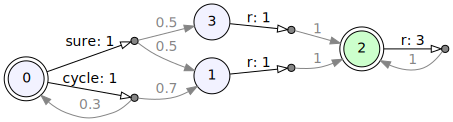

In [35]:
from fimdp.examples.cons_mdp import goal_leaning_2
gl2, T = goal_leaning_2()

basic2 = BasicES(gl2, 10, targets=T)
goal2 = GoalLeaningES(gl2, 10, targets=T)
goal2.show()

In [36]:
print(basic2.get_selector(BUCHI), goal2.get_selector(BUCHI), sep="\n")

[{0: 0——sure[1]——>{1: 0.5, 3: 0.5}}, {1: 1——r[1]——>{2: 1}}, {3: 2——r[3]——>{2: 1}}, {1: 3——r[1]——>{2: 1}}]
[{0: 0——cycle[1]——>{1: 0.7, 0: 0.3}}, {1: 1——r[1]——>{2: 1}}, {3: 2——r[3]——>{2: 1}}, {1: 3——r[1]——>{2: 1}}]
